# NYC 311 Dataset

Boroughs - location of incidents
- 5 Boroughs in NYC
- Manhattan, Brooklyn, Queens, Bronx, Staten Island
- There are some unspecified locations of incidents in the dataset
- Where the incident physically occurred.

Agencies - the city department responsible for resolving the incident
- All part of NYC government 
- Completely separate departments with their own funding, staffing, operational procedures, areas of responsibility, and service level expectations

- 311 categorizes and routes to a correct agency

### NYC 311 Agencies

1. NYPD (New York City Police Department)
- General Role: Public safety, law enforcement, quality-of-life enforcement
- 311 responsibilities include: noise complaints, illegal parking, blocked driveways, graffiti, public drinking, disorderly conduct, traffic enforcement complaints, homeless encampments

2. HPD (Housing Preservation and Development)
- General Role: Protecting residential housing quality and enforcing housing codes
- 311 responsibilities include: no heat / no hot water, plumbing leaks, mold/mildew, rodents and pests inside dwellings, broken locks/doors/windows, illegal landlord behavior or property neglect, building-wide maintenance issues

3. DSNY (Department of Sanitation)
- General Role: Waste management and cleanliness
- 311 responsibilities include: missed garbage collection, improper disposal, overflowing trash bins, illegal dumping, dirty sidewalks or streets, dead animal removal, recycling issues

4. DOT (Department of Transportation)
- General Role: Street, traffic, and public roadway infrastructure management
- 311 responsibilities include: potholes, broken or missing street signs, damaged traffic signals, streetlight outages, sidewalk damage, wrong way signs/visibility issues

5. DEP (Department of Environmental Protection)
- General Role: Water, air, sewer, and environmental quality
- 311 responsibilities include: water main breaks, sewer backups, water discoloration/water quality issues, construction noise, air quality complaints, industrial fumes, water pressure issues

6. DOB (Department of Buildings)
- General Role: Building construction safety, code enforcement, and permits
- 311 responsibilities include: unsafe building conditions, illegal construction, structural concerns, scaffolding issues, elevators out of service, failure to maintain fire escapes

7. DPR (Department of Parks & Recreation)
- General Role: Public parks, trees, recreational facilities
- 311 responsibilities include: Dead tree/tree limb removal, damaged playground equipment, park maintenance issues, overgrown trees damaging property, public pool or recreation center issues

8. DOHMH (Department of Health and Mental Hygiene)
- General Role: Public health regulation and disease prevention
- 311 responsibilities include: rodents in public spaces, restaurant sanitary complaints, public health hazards, standing water, smoking complaints, hazardous materials

9. DHS (Department of Homeless Services)
- General Role: Homeless outreach, shelters, social services
- 311 responsibilities include: homeless encampment reports, people in need of social services, issues at shelters, quality-of-life concerns involving homeless individuals

10. DCWP (Department of Consumer and Worker Protection)
- General Role: Consumer rights, business regulation, workplace fairness
- 311 responsibilities include: price gouging, business licensing issues, consumer fraud, employment law violations, scams, predatory business practices

11. TLC (Taxi and Limousine Commission)
- General Role: Regulation of taxis, Ubers, Lyfts, for-hire vehicles
- 311 responsibilities include: unsafe taxi/Uber driving, fare disputes, taxi refusal, overcharging, dirty or unsafe vehicles, illegal for-hire activity

12. DOE (Department of Education)
- General Role: School facilities, maintenance, and safety
- 311 responsibilities include: school building heating issues, school cleanliness, school food safety, leaks/pests/facility requests

13. OTI (Office of Technology and Innovation)
- General Role: Citywide IT infrastructure
- 311 responsibilities include: website outages, city system technical problems, 311 app issues, access problems for digital services

14. OOS (Office of Operations (Mayor’s Office))
- General Role: Cross-agency operations, oversight, and coordination
- 311 responsibilities include: oversight-level complaints, issues requiring escalation, administrative or inter-agency matters

15. EDC (Economic Development Corporation)
- General Role: Economic growth, waterfront management, industrial support
- 311 responsibilities include: some waterfront complaints, business district issues, public-private development maintenance concerns

The NYC 311 dataset exists to support:

### Operational decision-making
Identify which problems occur most often, when, and where, so the city can deploy staff more efficiently.
- incident numbers by boroughts/agencies 
 - incidents per capita per borough
 - agency load imbalance? 
- prediction of likelihood of each type of incidents by boroughs based on the frequencies of each type as well as by seasonal (is this enough with one year's data?)

### Trend detection
Understand long-term patterns (seasonality, rising complaints, emerging issues).
- how to avg resolution time for incidents generally trend over weeks/months as well as for each incident type
- is seasonality predictable? Perhaps with 5 boroughs and multiple agencies it may yield a credible result
- emerging issues shown by trend of number of each type of incident

“With one year of data, we can identify intra-year seasonality (winter heat complaints, summer noise spikes, etc.). Multi-year trend detection is possible if we expand this project later.”

improvements - use moving averages to smooth trends, use year-over-year comparison is additional years are added later

### Service performance evaluation
Measure how long different agencies take to resolve complaints.
- median/mean resolution time per agency
- median/mean resolution time per complaint type
- different in resolution speed across boroughs
- use distributions, not only averages
 - resolution time often have long right tails - extreme delays

### Resource allocation
Decide which boroughs or agencies need more staffing or funding.
- depends on resolution time and number of incidents. analysis provided above

### Predictive modeling (research + analytics)
Predict future incident volumes or resolution times to improve service planning.
- overall (with the whole dataset)
- by boroughs
- by agencies

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

plt.rcParams["figure.figsize"] = (10, 5)

BASE_DIR = Path.cwd().parents[0]  # notebooks/ -> project root
CLEAN_PATH = BASE_DIR / "data" / "cleaned" / "nyc_311_full_year_cleaned.parquet"

df = pd.read_parquet(CLEAN_PATH)
df.shape

(3207336, 14)

In [38]:
df.head(10)

,created_date,closed_date,complaint_type,descriptor,agency,borough,incident_zip,latitude,longitude,resolution_hours,month,hour,weekday,is_weekend
0,2024-12-27 05:01:12,2024-12-27 09:04:50,Illegal Parking,Blocked Hydrant,NYPD,QUEENS,11417,40.67604759711457,-73.83285041094713,4.060555,12.0,5.0,4.0,0.0
1,2024-12-27 05:03:45,2024-12-27 11:41:50,Blocked Driveway,No Access,NYPD,BRONX,10466,40.88614032903141,-73.85260382773865,6.634722,12.0,5.0,4.0,0.0
2,2024-12-27 05:03:51,2024-12-31 15:38:47,HEAT/HOT WATER,ENTIRE BUILDING,HPD,QUEENS,11377,40.74133262269033,-73.92076399754987,106.582222,12.0,5.0,4.0,0.0
3,2024-12-27 05:04:10,2024-12-27 08:51:28,HEAT/HOT WATER,ENTIRE BUILDING,HPD,BRONX,10458,40.871162633641255,-73.88671175432482,3.788333,12.0,5.0,4.0,0.0
4,2024-12-27 05:07:03,2024-12-27 05:07:03,Building/Use,Illegal. Commercial Use In Resident Zone,DOB,BROOKLYN,11208,40.673488433040575,-73.86095438129898,0.000000,12.0,5.0,4.0,0.0
5,2024-12-27 05:07:46,2024-12-29 18:12:55,HEAT/HOT WATER,ENTIRE BUILDING,HPD,BROOKLYN,11225,40.66515315606502,-73.95373536849284,61.085835,12.0,5.0,4.0,0.0
6,2024-12-27 05:08:04,2024-12-27 06:45:54,Blocked Driveway,No Access,NYPD,QUEENS,11354,40.769700037591605,-73.8280267519398,1.630556,12.0,5.0,4.0,0.0
7,2024-12-27 05:09:19,2024-12-27 05:32:29,Illegal Parking,Blocked Hydrant,NYPD,QUEENS,11385,40.70550471181509,-73.88717722773042,0.386111,12.0,5.0,4.0,0.0
8,2024-12-27 05:10:01,2024-12-27 05:38:32,Noise - Residential,Loud Music/Party,NYPD,BROOKLYN,11212,40.657992266567,-73.90170315092821,0.475278,12.0,5.0,4.0,0.0
9,2024-12-27 05:10:38,2024-12-30 20:29:53,HEAT/HOT WATER,APARTMENT ONLY,HPD,QUEENS,11419,40.68500126275528,-73.82924755935618,87.320831,12.0,5.0,4.0,0.0


In [53]:
# Remove df[latitude] and df[longitude] 
df2 = df.drop(columns=["latitude", "longitude"])

In [61]:
df2.columns

Index(['created_date', 'closed_date', 'complaint_type', 'descriptor', 'agency',
       'borough', 'incident_zip', 'resolution_hours', 'month', 'hour',
       'weekday', 'is_weekend'],
      dtype='object')

In [62]:
df2['complaint_type'].unique

<bound method Series.unique of 0              Illegal Parking
1             Blocked Driveway
2               HEAT/HOT WATER
3               HEAT/HOT WATER
4                 Building/Use
                  ...         
3207331       Blocked Driveway
3207332      Abandoned Vehicle
3207333    Noise - Residential
3207334    Noise - Residential
3207335     Noise - Commercial
Name: complaint_type, Length: 3207336, dtype: object>

In [60]:
df2.head(10)

,created_date,closed_date,complaint_type,descriptor,agency,borough,incident_zip,resolution_hours,month,hour,weekday,is_weekend
0,2024-12-27 05:01:12,2024-12-27 09:04:50,Illegal Parking,Blocked Hydrant,NYPD,QUEENS,11417,4.060555,12.0,5.0,4.0,0.0
1,2024-12-27 05:03:45,2024-12-27 11:41:50,Blocked Driveway,No Access,NYPD,BRONX,10466,6.634722,12.0,5.0,4.0,0.0
2,2024-12-27 05:03:51,2024-12-31 15:38:47,HEAT/HOT WATER,ENTIRE BUILDING,HPD,QUEENS,11377,106.582222,12.0,5.0,4.0,0.0
3,2024-12-27 05:04:10,2024-12-27 08:51:28,HEAT/HOT WATER,ENTIRE BUILDING,HPD,BRONX,10458,3.788333,12.0,5.0,4.0,0.0
4,2024-12-27 05:07:03,2024-12-27 05:07:03,Building/Use,Illegal. Commercial Use In Resident Zone,DOB,BROOKLYN,11208,0.000000,12.0,5.0,4.0,0.0
5,2024-12-27 05:07:46,2024-12-29 18:12:55,HEAT/HOT WATER,ENTIRE BUILDING,HPD,BROOKLYN,11225,61.085835,12.0,5.0,4.0,0.0
6,2024-12-27 05:08:04,2024-12-27 06:45:54,Blocked Driveway,No Access,NYPD,QUEENS,11354,1.630556,12.0,5.0,4.0,0.0
7,2024-12-27 05:09:19,2024-12-27 05:32:29,Illegal Parking,Blocked Hydrant,NYPD,QUEENS,11385,0.386111,12.0,5.0,4.0,0.0
8,2024-12-27 05:10:01,2024-12-27 05:38:32,Noise - Residential,Loud Music/Party,NYPD,BROOKLYN,11212,0.475278,12.0,5.0,4.0,0.0
9,2024-12-27 05:10:38,2024-12-30 20:29:53,HEAT/HOT WATER,APARTMENT ONLY,HPD,QUEENS,11419,87.320831,12.0,5.0,4.0,0.0


In [ ]:
complaint_type

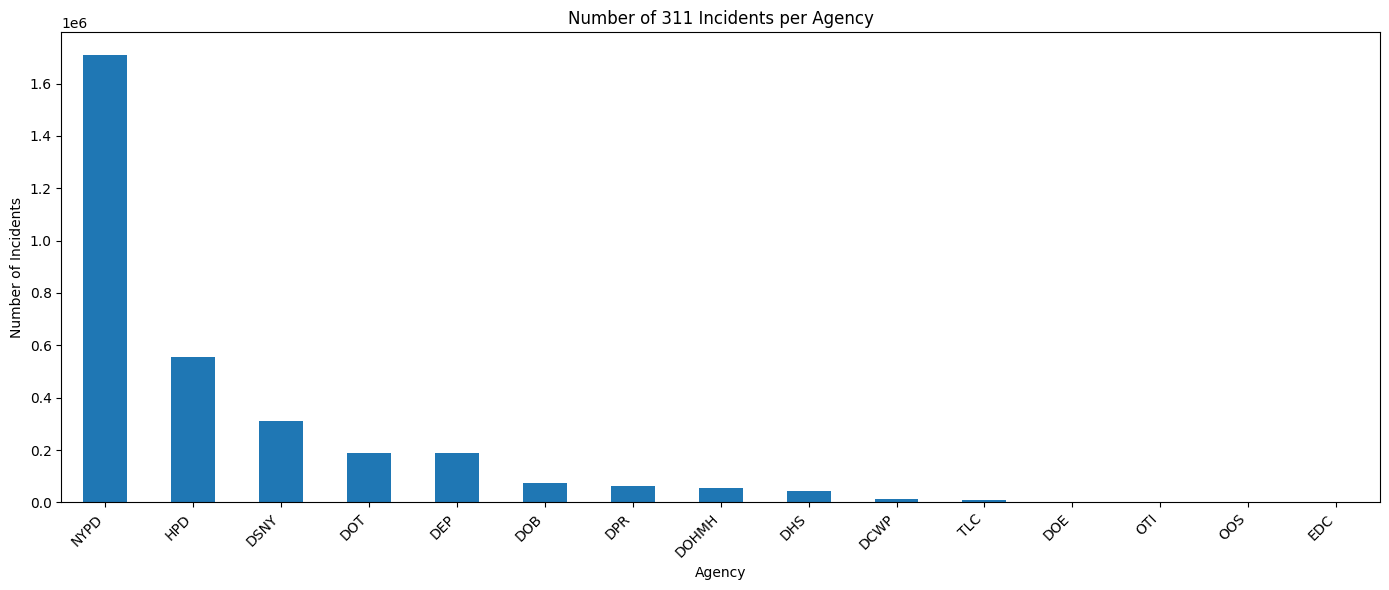

In [54]:
agency_counts = df2['agency'].value_counts()

plt.figure(figsize=(14, 6))
agency_counts.plot(kind='bar')
plt.title("Number of 311 Incidents per Agency")
plt.xlabel("Agency")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [59]:
df2[complaint_type].unique()

NameError: name 'complaint_type' is not defined

In [50]:
agency_counts = df['agency'].value_counts()

agency_table = pd.DataFrame({
    "Agency": agency_counts.index,
    "Number of Incidents": agency_counts.values
})

agency_table["Number of Incidents"] = agency_table["Number of Incidents"].map(lambda x: f"{x:,}")

print("Top Agencies by Number of Incidents:\n")
print(agency_table.to_string(index=False))

Top Agencies by Number of Incidents:

Agency Number of Incidents
  NYPD           1,710,236
   HPD             554,921
  DSNY             310,102
   DOT             189,489
   DEP             187,732
   DOB              73,574
   DPR              62,877
 DOHMH              53,127
   DHS              42,782
  DCWP              12,002
   TLC               9,557
   DOE                 681
   OTI                 187
   OOS                  67
   EDC                   2


In [51]:
borough_counts = df['borough'].value_counts()

borough_table = pd.DataFrame({
    "Borough": borough_counts.index,
    "Number of Incidents": borough_counts.values
})

borough_table["Number of Incidents"] = borough_table["Number of Incidents"].map(lambda x: f"{x:,}")

print("Incidents by Borough:\n")
print(borough_table.to_string(index=False))

Incidents by Borough:

      Borough Number of Incidents
     BROOKLYN             949,794
       QUEENS             775,941
        BRONX             747,243
    MANHATTAN             612,980
STATEN ISLAND             119,695
  Unspecified               1,683


# Rare-category sparsity

In [ ]:
# Create line graph of boroughs/agencies for monthly average resolution hours distribution in 2025

In [45]:
df['agency'].unique()

array(['NYPD', 'HPD', 'DOB', 'DEP', 'DSNY', 'DOT', 'DOHMH', 'DPR', 'DHS',
       'DCWP', 'TLC', 'OTI', 'DOE', 'EDC', 'OOS'], dtype=object)

In [46]:
df['borough'].unique()

array(['QUEENS', 'BRONX', 'BROOKLYN', 'STATEN ISLAND', 'MANHATTAN',
       'Unspecified'], dtype=object)

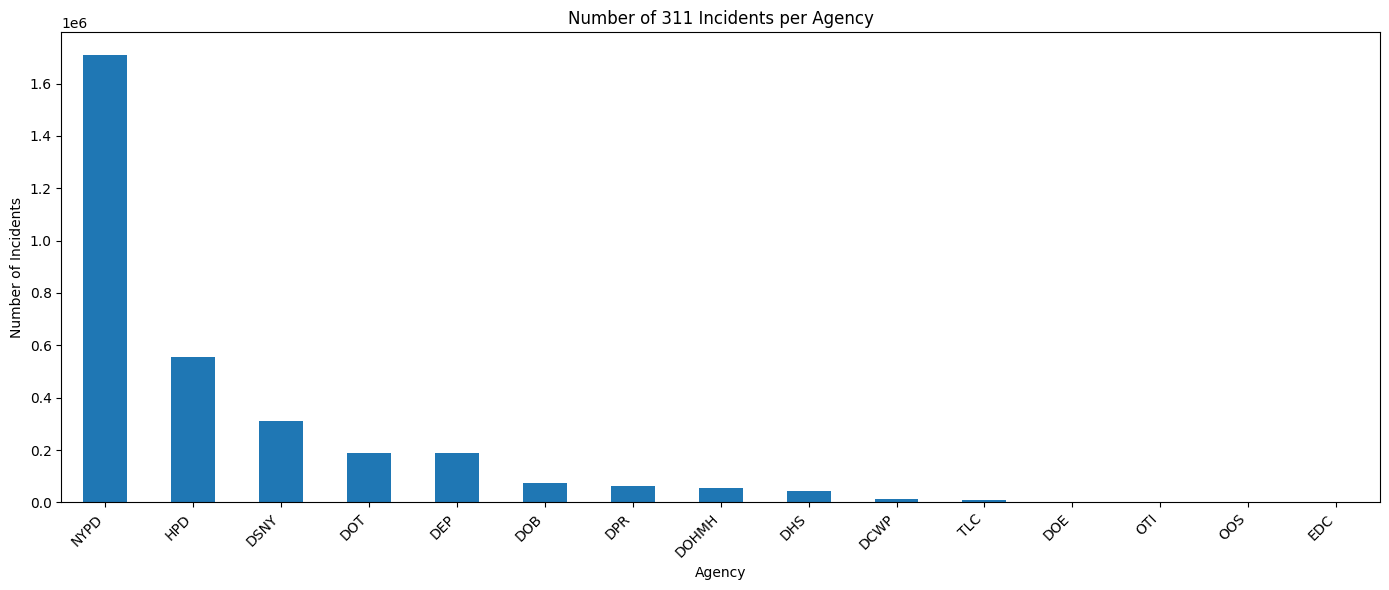

In [39]:
agency_counts = df['agency'].value_counts()

plt.figure(figsize=(14, 6))
agency_counts.plot(kind='bar')
plt.title("Number of 311 Incidents per Agency")
plt.xlabel("Agency")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

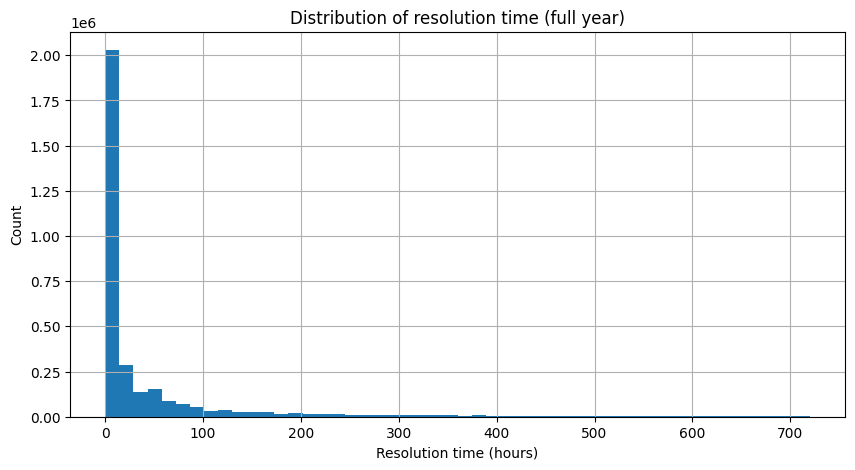

In [22]:
df["resolution_hours"].describe()
df["resolution_hours"].hist(bins=50)
plt.xlabel("Resolution time (hours)")
plt.ylabel("Count")
plt.title("Distribution of resolution time (full year)")
plt.show()

In [23]:
# Do quartiles - show as a box plot 

In [24]:
# Top complaint types and agencies
top_complaints = df["complaint_type"].value_counts().head(30).index
top_agencies = df["agency"].value_counts().head(20).index

df_model = df[
    df["complaint_type"].isin(top_complaints)
    & df["agency"].isin(top_agencies)
].copy()

df_model.shape

(2725841, 14)

In [25]:
n_sample = min(300_000, len(df_model))
df_sample = df_model.sample(n=n_sample, random_state=42)
df_sample.shape

(300000, 14)

In [26]:
target_col = "resolution_hours"

feature_cols = [
    "complaint_type",
    "borough",
    "agency",
    "month",
    "hour",
    "weekday",
    "is_weekend",
]

df_sample = df_sample.dropna(subset=feature_cols + [target_col]).copy()

X_raw = df_sample[feature_cols]
y = df_sample[target_col]

X_raw.head()


,complaint_type,borough,agency,month,hour,weekday,is_weekend
33746,Illegal Parking,QUEENS,NYPD,12.0,22.0,0.0,0.0
2096744,Water System,BROOKLYN,DEP,8.0,17.0,3.0,0.0
1627346,Water System,QUEENS,DEP,7.0,7.0,1.0,0.0
992057,Water System,BROOKLYN,DEP,4.0,14.0,4.0,0.0
995086,Noise - Residential,BRONX,NYPD,4.0,21.0,4.0,0.0


In [27]:
categorical_cols = ["complaint_type", "borough", "agency"]
numeric_cols = ["month", "hour", "weekday", "is_weekend"]

X_categorical = pd.get_dummies(X_raw[categorical_cols], drop_first=True)
X_numeric = X_raw[numeric_cols]

X = pd.concat([X_numeric, X_categorical], axis=1)

X.shape, y.shape

((300000, 45), (300000,))

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=153
)

X_train.shape, X_test.shape

((240000, 45), (60000, 45))

In [30]:
baseline = DummyRegressor(strategy="mean")
baseline.fit(X_train, y_train)

y_pred_base = baseline.predict(X_test)
base_mae = mean_absolute_error(y_test, y_pred_base)
base_r2 = r2_score(y_test, y_pred_base)

base_mae, base_r2

(45.86480712890625, -4.303455352783203e-05)

In [31]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred_lr = linreg.predict(X_test)
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

lr_mae, lr_r2

(29.474184036254883, 0.36729997396469116)

In [32]:
rf = RandomForestRegressor(
    n_estimators=150,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

rf_mae, rf_r2

(26.48463048206785, 0.33925852804069245)

In [34]:
results = pd.DataFrame({
    "model": ["Baseline (mean)", "Linear Regression", "Random Forest"],
    "MAE_hours": [base_mae, lr_mae, rf_mae],
    "R2": [base_r2, lr_r2, rf_r2],
})
results

,model,MAE_hours,R2
0,Baseline (mean),45.864807,-0.000043
1,Linear Regression,29.474184,0.367300
2,Random Forest,26.484630,0.339259


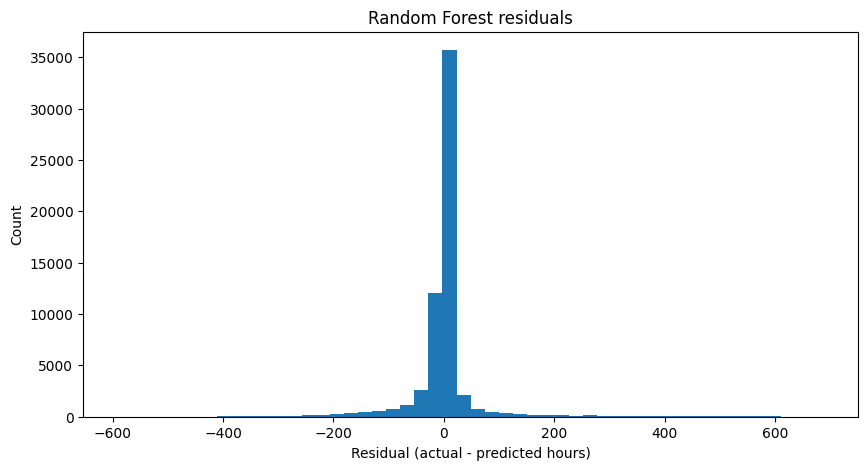

Residual mean: -1.2246979089089345
Residual std: 70.0081529863498


In [35]:
residuals = y_test - y_pred_rf

plt.hist(residuals, bins=50)
plt.xlabel("Residual (actual - predicted hours)")
plt.ylabel("Count")
plt.title("Random Forest residuals")
plt.show()

print("Residual mean:", residuals.mean())
print("Residual std:", residuals.std())

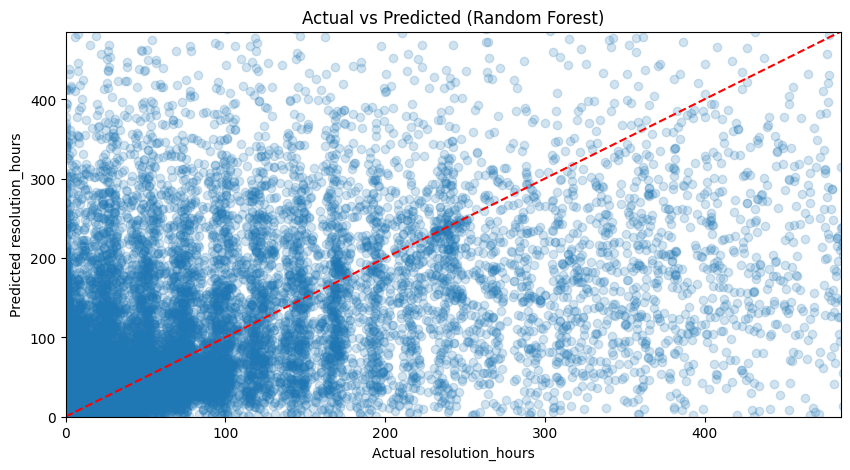

In [36]:
plt.scatter(y_test, y_pred_rf, alpha=0.2)
plt.xlabel("Actual resolution_hours")
plt.ylabel("Predicted resolution_hours")
plt.title("Actual vs Predicted (Random Forest)")
plt.plot([0, y_test.max()], [0, y_test.max()], "r--")
plt.xlim(0, y_test.quantile(0.99))
plt.ylim(0, y_test.quantile(0.99))
plt.show()

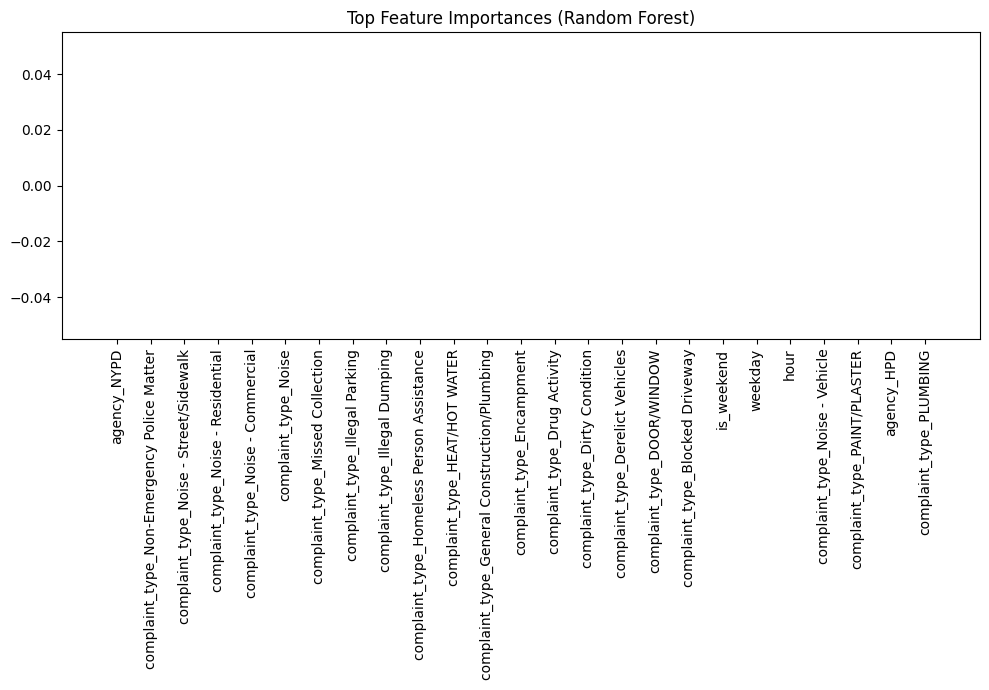

In [37]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

top_n = 25
top_idx = indices[:top_n]

plt.figure(figsize=(10, 7))
plt.bar(range(top_n), importances[top_idx])
plt.xticks(range(top_n), feature_names[top_idx], rotation=90)
plt.title("Top Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()